In [1]:
import numpy as np
from tqdm import tqdm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from tsmoothie.utils_func import sim_randomwalk, sim_seasonal_data
from tsmoothie.smoother import *

from sklearn.metrics import mean_squared_error

In [2]:
### SIMULATE DATA ###

np.random.seed(555)

n_series, timesteps = 100, 600

original = sim_randomwalk(n_series=n_series, timesteps=timesteps, 
                          process_noise=1, measure_noise=0)
seasons = sim_seasonal_data(n_series=n_series, timesteps=timesteps, 
                            freq=24, measure_noise=4, level=0, amp=10)
original = original + seasons

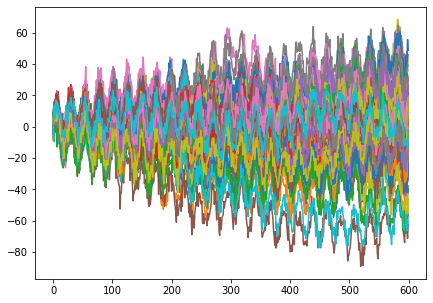

In [3]:
plt.figure(figsize=(7,5))
plt.plot(original.T)
np.set_printoptions(False)

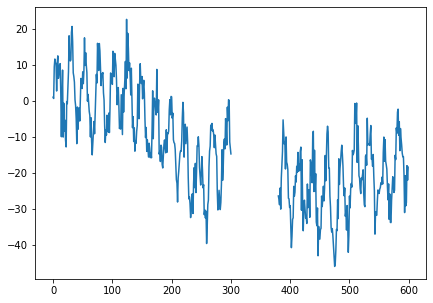

In [4]:
### MASK DATA ###

mask = np.logical_and(np.arange(timesteps)>300, np.arange(timesteps)<380)

restored = np.copy(original[[0]])
restored[:,mask] = np.nan

plt.figure(figsize=(7,5))
plt.plot(restored.T)
np.set_printoptions(False)

In [5]:
### OPERATE SMOOTHING ###

smoother = KalmanSmoother(component='level_season', n_seasons=24,
                          component_noise={'level':0.01,'season':0.01})
smoother.smooth(restored)

<tsmoothie.smoother.KalmanSmoother>

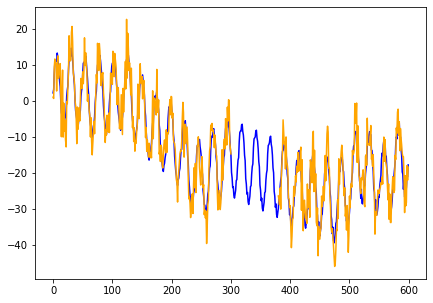

In [6]:
### COMPARE RECONSTRUCTION WITH ORIGINAL ###

plt.figure(figsize=(7,5))
plt.plot(smoother.smooth_data.T, c='blue')
plt.plot(smoother.data.T, c='orange')
np.set_printoptions(False)

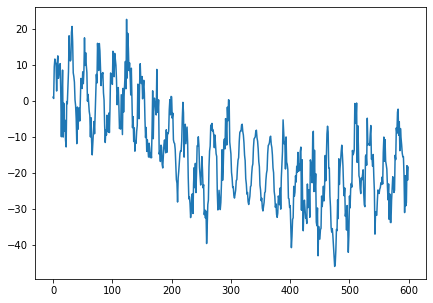

In [7]:
### RECOVERY DATA ###

restored[:,mask] = smoother.smooth_data[:,mask]

plt.figure(figsize=(7,5))
plt.plot(restored.T)
np.set_printoptions(False)

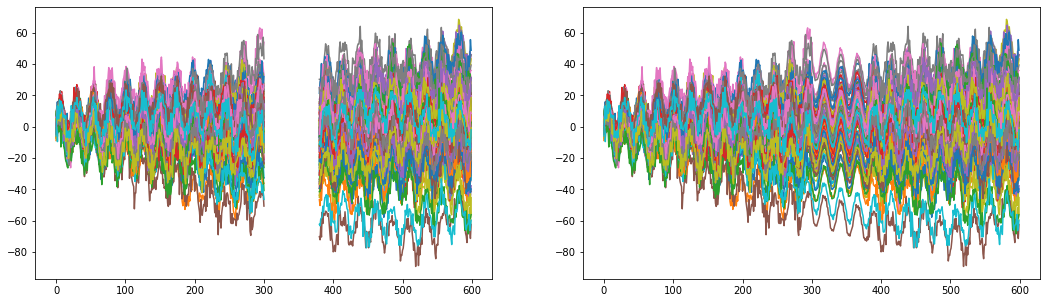

In [8]:
### SIMULATION WITH N SERIES, SINGLE INTERVAL AND KALMAN ###

mask = np.logical_and(np.arange(timesteps)>300, np.arange(timesteps)<380)

restored = np.copy(original)
restored[:,mask] = np.nan

plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(restored.T)

smoother = KalmanSmoother(component='level_season', n_seasons=24,
                          component_noise={'level':0.01,'season':0.01})
smoother.smooth(restored)

restored[:,mask] = smoother.smooth_data[:,mask]

plt.subplot(122)
plt.plot(restored.T)
np.set_printoptions(False)

In [9]:
### SIMULATION WITH N SERIES, MULTIPLE INTERVAL LENGTHS AND KALMAN ###

errors1 = {}

for i in tqdm(range(200, 500, 100)):
    
    mask = np.logical_and(np.arange(timesteps)>100, np.arange(timesteps)<i)

    restored = np.copy(original)
    restored[:,mask] = np.nan
    
    smoother = KalmanSmoother(component='level_season', n_seasons=24,
                              component_noise={'level':0.01,'season':0.01})
    smoother.smooth(restored)

    restored[:,mask] = smoother.smooth_data[:,mask]
    errors1[i-100] = mean_squared_error(original.T, restored.T)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.02s/it]


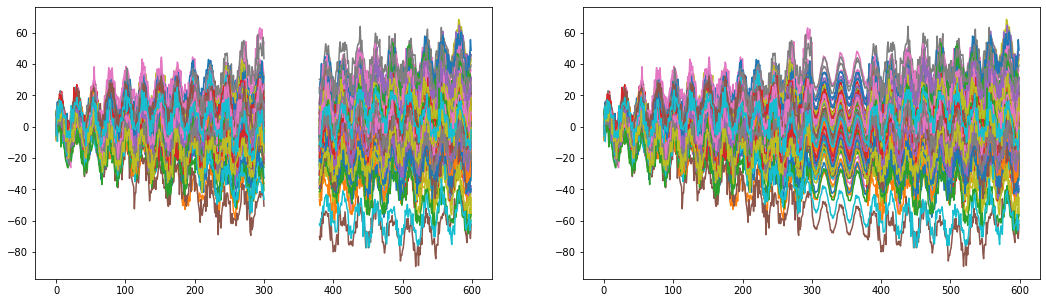

In [10]:
### SIMULATION WITH N SERIES, SINGLE INTERVAL AND SEASONAL DECOMPOSITION ###

mask = np.logical_and(np.arange(timesteps)>300, np.arange(timesteps)<380)

restored = np.copy(original)
restored[:,mask] = np.nan

plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(restored.T)

not_nan = np.logical_not(np.isnan(restored))
indices = np.arange(restored.shape[1])
for i in range(n_series):
    interpolation = interp1d(indices[not_nan[i]], restored[i,not_nan[i]])
    restored[i] = interpolation(indices)

smoother = DecomposeSmoother(smooth_type='convolution', periods=24,
                             window_len=200, window_type='ones')
smoother.smooth(restored)

restored[:,mask] = smoother.smooth_data[:,mask]

plt.subplot(122)
plt.plot(restored.T)
np.set_printoptions(False)

In [11]:
### SIMULATION WITH N SERIES, MULTIPLE INTERVAL LENGTHS AND SEASONAL DECOMPOSITION ###

errors2 = {}

for i in tqdm(range(300, 600, 100)):
    
    mask = np.logical_and(np.arange(timesteps)>200, np.arange(timesteps)<i)

    restored = np.copy(original)
    restored[:,mask] = np.nan
    
    not_nan = np.logical_not(np.isnan(restored))
    indices = np.arange(restored.shape[1])
    for s in range(n_series):
        interpolation = interp1d(indices[not_nan[s]], restored[s,not_nan[s]])
        restored[s] = interpolation(indices)

    smoother = DecomposeSmoother(smooth_type='convolution', periods=24,
                                 window_len=(i-100), window_type='ones')
    smoother.smooth(restored)

    restored[:,mask] = smoother.smooth_data[:,mask]
    errors2[i-100] = mean_squared_error(original.T, restored.T)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.00it/s]


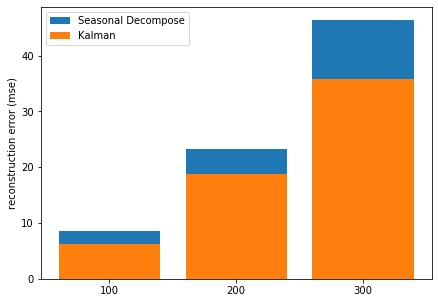

In [12]:
### COMPARE RECONSTRUCTION ERRORS ###

plt.figure(figsize=(7,5))
plt.bar(range(3), errors2.values(), label='Seasonal Decompose')
plt.bar(range(3), errors1.values(), label='Kalman')
plt.xticks(range(len(errors1.keys())), errors1.keys())
plt.ylabel('reconstruction error (mse)'); plt.legend()
np.set_printoptions(False)